# A Contextual-Bandit Approach to Personalized News Article Recommendation-论文学习

github地址：[bandit-learning](https://github.com/yijunquan-afk/bandit-learning/tree/master/03-papers)

## 摘要

该算法根据用户和文章的上下文信息依次选择文章为用户服务，同时根据用户点击反馈调整其文章选择策略，以最大化用户总点击量。

## 问题定义

个性化新闻文章推荐问题可以建模为一个具有上下文信息的多臂老虎机问题。我们称其为上下文老虎机（`contextual bandit`）。使用算法 $A$ 进行离散化实验 $t=1,2,3,\cdots$。在试验 $t$ 中：

1. 该算法观察当前用户 $u_t$ 和臂或动作的集合$\mathcal{A}_t$，以及它们的特征向量 $x_{t,a} $，其中$a\in \mathcal{A}_t$。特征向量 $x_t,a$概括了用户  $u_t$  和 臂 $a$ 两者的信息，称之为上下文（`context`）。
2. 基于先前试验中观察到的奖励，算法 $A$ 选择一个臂 $a_t\in\mathcal{A}_t$，并收到奖励 $r_{t,a_t}$，其期望取决于用户  $u_t$  和 臂 $a$ 。
3. 然后，该算法使用新的观测值 $x_{t,a} ,a_t,r_{t,a_t}$ 来改进臂选择策略。这里需要强调的是，对于未选择的臂 $a \ne a_t$，观察其$no-feedback$（即收益$r_{t,a}$）是很重要的。

在上面的过程中，算法 $A$ 的`总 T 轮奖励`被定义为 $\sum_{t=1}^T r_{t,a_t}$，同样的，我们可以定义`最优期望 T 轮奖励`$\text{E}\left[\sum_{t=1}^Tr_{t,a_t^*}\right]$，其中其中 $a_t^*$ 是在试验 $t$ 时具有最大预期收益的臂。我们的目标是设计算法 $A$ ，使上面的预期总收益最大化。等价来说，就是找到一个算法使其关于最优臂选择策略的悔值（`regret`）最小化。这里，算法 $A$ 的 T 轮悔值 $R_A(T)$ 被形式化地定义为:
$$
R_A(T)\ \overset{\text{def}}{=} \  \text{E}\left[\sum_{t=1}^Tr_{t,a_t^*}\right] - \text{E}\left[\sum_{t=1}^Tr_{t,a_t}\right] \tag{1}
$$
一般上下文强盗问题的一个重要特殊情况是著名的K臂老虎机问题（`K-armed bandit`），其中

1. 臂集 $\mathcal{A}_t$ 保持不变，每轮$t$ 都有不变的 $K$ 个臂
2. 用户$u_t$ （即上下文$({x}_{t,1}，\cdots，{x}_{t,K})$）对于所有$t$是相同的。由于臂集和上下文在每次试验中都是恒定的，，因此我们也将这种类型的bandit称为上下文无关老虎机模型（`context-free bandit`）。

在文章推荐的上下文中，我们可以将池中的文章视为臂。当点击所呈现的文章时，会产生 $1$ 的奖励；否则奖励为$0$。根据这种收益定义，一篇文章的预期收益就是它的点击率(`clickthrough rate CTR`)，选择一篇具有最大点击率的文章相当于最大化用户的预期点击次数，这反过来又与我们bandit公式中的最大化总预期收益相同。

此外，在web服务中，我们经常可以访问用户信息，这些信息可以用来推断用户的兴趣，并选择她可能最感兴趣的新闻文章。


## 算法

鉴于UCB方法在无上下文bandit算法中的渐近最优性和强悔值界，设计类似的算法来解决上下文bandit问题是很有诱惑力的。给定奖励函数的某种参数形式，存在许多方法从数据估计参数的置信区间，我们可以用这些置信区间来计算估计臂奖励的UCB（置信上限）。然而，这些方法一般来说是代价较高的。

当奖励模型是线性时，可以有效地以封闭形式计算置信区间，并将此算法称为 $LinUCB$。为了便于阐述，我们首先描述**不相交线性模型**的简单形式，然后考虑混合模型的一般情况。

### 不相交线性模型的LinUCB

我们假设臂 $a$ 的期望收益在其 $d$ 维特征 ${x}_{t,a}$ 中是线性的， ${x}_{t,a}$ 具有某个未知系数向量 $\pmb{\theta}_a^*$ ；也就是说，对于所有 $t$，
$$
\text{E}[r_{t,a}|{x}_{t,a}]\ =\ \bold{x}_{t,a}^T\ \pmb{\theta}_a^*\tag{2}
$$
这个模型是不相交的(`disjoint`)，因为参数在不同的臂间不共享。

设 $\bold{D}_a$ 维数为 $m\times d$ 的矩阵，它的行对应 $m$ 个训练输入(例如，先前文章 $a$ 中观察到的 $m$ 个上下文)，$\bold{c}_a\in\mathbb{R}^m$ 为对应的响应向量(如对应的 $m$ 个点击/不点击反馈)。将岭回归(`ridge regression`)应用于训练数据$(\bold{D}_a, \bold{c}_a)$，给出系数的估计:

> 问题为$\bold{D}_{a}\cdot \theta_a = \bold{c}$
>
> 加上一个L2正则化项的损失函数如下
> $$
> Loss_a(\bold{\theta}_a)=|| \bold{D}_{a}\cdot \theta_a-\bold{c}_a||^2+||\bold{I}_a\theta_a||^2
> $$
> 解得：

$$
\hat{\bold{\theta}}_a=(\bold{D}_a^T\bold{D}_a+\bold{I}_d)^{-1}\bold{D}_a^T\bold{c}_a \tag{3}
$$

其中 $\bold{I}_d$ 是 $d\times d$ 的单位矩阵，当 $\bold{c}_a$ 中的分量独立于 $\bold{D}_a$ 中的相应行时，可以证明至少有 $1−δ$ 的概率，
$$
\left|\bold{x}_{t,a}^T\hat{\pmb{\theta}}_a-\text{E}[r_{t,a}|\bold{x}_{t,a}]\right| \le \alpha \sqrt{\bold{x}_{t,a}^T(\bold{D}_a^T\bold{D}_a+\bold{I}_d)^{-1}\bold{x}_{t,a}} \tag{4}
$$
其中 $δ>0$ 为超参 ，$x_{t,a} \in \mathbb{R}^d$，$\alpha=1+\sqrt{\frac{\ln(2/δ)}{2}}$为一个常数。$\bold{x}_{t,a}^T\hat{\pmb{\theta}}_a$ 是观测到的臂 $a$ 被选上的概率，$\text{E}[r_{t,a}|\bold{x}_{t,a}]$则是真实概率。上述不等式为臂 $a$ 的预期收益提供了一个合理严格的UCB，从中可以得出一个UCB型的选择策略：在第 $t$ 轮中，选择
$$
a_t \ \overset{\text{def}}{=} \ \arg\max_{a\in\mathcal{A}_t} \left(\bold{x}_{t,a}^T\hat{\pmb{\theta}}_a+\alpha
\sqrt{\bold{x}_{t,a}^T \bold{A}_a^{-1}\bold{x}_{t,a}}\right)\tag{5}
$$
其中$\bold{A}\overset{\text{def}}{=}\bold{D}_a^T\bold{D}_a+\bold{I}_d$

当前模型中，预期收益 $\bold{x}_{t,a}^T\pmb{\theta}_a^*$ 的预测方差(variance)被估计为 $\bold{x}_{t,a}^T \bold{A}_a^{-1}\bold{x}_{t,a}$，然后 $\sqrt{\bold{x}_{t,a}^T \bold{A}_a^{-1}\bold{x}_{t,a}}$ 成为标准差(standard deviation)

算法1给出了整个 $LinUCB$ 算法的详细描述，其唯一的输入参数是 $α$ 。注意，式(4)中给出的 $α$ 值在某些应用中可能过于保守，因此优化该参数在实际中可能会导致更高的总收益。像所有的UCB方法一样， $LinUCB$ 总是选择具有最高UCB的臂(如公式(5))。

![image-20230221151558786](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230221151558786.png)

1. 输入参数 $α$ 
2. 对于 $t=1,2,3,\ldots,T$
   - 观察所有臂 $a\in \mathcal{A}_t$ 的特征值 $x_{t,a} \in \mathbb{R}^d$。
   - 对于所有的臂 $a\in \mathcal{A}_t$ ：
     - 如果$a$ 是新的臂
       - $\bold{A}_a \leftarrow \bold{I}_d$（d维单位矩阵）
       - $\bold{b}_a\leftarrow \bold{0}_{d\times 1}$（d维零向量）
     - $\hat{\bold{\theta}}_a\leftarrow \bold{A}_a^{-1}\bold{b}_a$
     - $p_{t,a} \leftarrow \hat{\pmb{\theta}}_a^T \bold{x}_{t,a} +\alpha\sqrt{\bold{x}_{t,a}^T\bold{A}_a^{-1}\bold{x}_{t,a}}$ 
   - 选择使得 $p_{t,a}$ 最大的臂，观察真实的奖励 $r_t$。
   - $\bold{A}_{a_t}\leftarrow \bold{A}_{a_t}+\bold{x}_{t,a_t}\bold{x}_{t,a_t}^T$
   - $\bold{b}_{a_t} \leftarrow\bold{b}_{a_t}+r_t\bold{x}_{t,a_t}$

其中$\bold{A}_a\overset{\text{def}}{=}\bold{D}_a^T\bold{D}_a+\bold{I}_d$，$\bold{b}_a\overset{\text{def}}{=}\bold{D}_a^T\cdot \bold{c}_a$

### 混合线性模型的LinUCB

不相交线性模型由于参数是不相交的，因此 $\bold{D}_a^T\bold{D}_a+\bold{I}_d$ 的逆可以很容易地计算出来，线性参数解 $\theta_a$ 不受其他手臂训练数据的影响，因此也可以单独计算。接下来考虑一种更复杂的情况，臂的参数既有独立部分，也有和其他臂共享的部分。

臂之间共享信息是很有帮助的。形式上，我们采用以下混合模型，在公式（2）的右侧增加另一个线性项
$$
\text{E}[r_{t,a}|{x}_{t,a}]\ =\ \bold{z}_{t,a}^T\ \pmb{\beta}^*+ \bold{x}_{t,a}^T\ \pmb{\theta}_a^*\tag{6}
$$
其中 $\bold{z}_{t,a}∈\mathbb{R}^k$ 是当前用户/文章组合的特征，$\pmb{\beta}^*$ 是**所有臂共有的未知系数向量**。这个模型是混合的，因为有些系数$\pmb{\beta}^*$ 为所有臂所共有，而另一些系数 $\pmb{\theta}_a^*$ 则不是。

对于混合模型，我们不能再使用算法1，因为各臂的置信区间由于共享特征不是独立的。幸运的是，有一种计算UCB的有效方法，其推理思路与前一节相同。推导主要依赖于分块矩阵反演技术。

![image-20230221162644556](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230221162644556.png)

该算法在计算上是有效的，因为该算法中的构件块 $(A_0、b_0、A_a、B_a和b_a)$ 都有固定的尺寸，可以递增更新。此外，与 $\mathcal{A}$ 中不存在的臂相关的量不再参与计算。最后，我们还可以周期性地计算和缓存逆（$A_0^{-1}$和$A_1^{-1}$），而不是在每次试验结束时计算和缓存，从而将每次试验的计算复杂度降低到 $O(d^2+k^2)$。

## 评估方法

不同于其他监督学习，在线学习算法的评估方法不那么容易。由于是探测问题，如果不上线，就没办法探到算法希望的内容一个方式是根据离线数据构造一个模拟器，但是这种模拟器会引入bias。我们提出了一个没有bias的简单实现。

- 我们假设有若干未知的分布 $D$ 服从独立同分布，$(\bold{x}_{1}, ..., \bold{x}_{K}, r_{1}, \ldots, r_{K})$。
- 每个分布包含了所有臂的可观测特征向量与隐含的奖励。我们还假设可以访问由日志政策与现实世界的交互所产生的大量记录事件序列。
- 每个这样的事件都由上下文向量 $（\bold{x}_{1}, ..., \bold{x}_{K}）$，一个选定的臂 $a$ 和由此观察到的奖励 $r_a$组成。简单起见，我们把实
- 实验的事件流看作是无限的，但是实验所需的事件是有上限的。

我们的目标是利用这些数据来评估一个bandit算法 $π$ 。形式上， $π$ 是一个(可能是随机的)映射，从历史 $t-1$ 个事件 $h_{t-1}$，以及当前的上下文特征向量 $（\bold{x}_{t1}, ..., \bold{x}_{tK}）$映射到在 $t$ 时刻选择臂 $a$。算法如下所示

![image-20230221164820131](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230221164820131.png)

- 该方法将策略 $π$ 和设定数量的“good”事件 $T$ 作为输入，以此作为评估的基础。然后，我们逐一查看记录的事件流。
- 如果给定当前历史 $t−1$ ，碰巧策略 $π$ 选择了与日志策略选择的臂 $a$ 相同，那么该事件被保留，也就是说，被添加到历史中，总收益 $R_t$ 被更新。否则事件被忽略，算法继续处理下一个事件，而不改变其状态。
- 值得注意的是，日志策略选择臂的策略是均匀随机选择，所以每个事件被算法保留的概率 $\frac{1}{K}$，并且各自是独立的。

根据真实世界事件评估策略和使用策略评估器对日志事件流评估策略是等效的。

## 实验
### 雅虎的Today模块

Today模块是雅虎首页，如下图所示。Today模块中的默认“Featured”选项卡突出显示了四篇高质量文章中的一篇，，而这四篇文章是从人工编辑每小时更新一次的文章池中选择的。如图所示，页脚位置有四篇文章，索引为F1-F4。每篇文章都由一张小图片和一个标题表示。四篇文章中的一篇被突出显示在Story位置，配有一张大图、一个标题和一个简短的摘要以及相关链接。默认情况下，位于F1的文章在Story位置突出显示。如果用户对文章感兴趣，可以点击Story位置的高亮文章阅读更多细节。事件被记录为故事点击。为了吸引访问者的注意力，我们会根据个人兴趣对可用文章进行排名，并在Story位置突出最吸引每位访问者的文章。

![image-20230221191647620](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230221191647620.png)

### 数据收集

我们在2009年5月从一个随机的bucket中收集事件。用户按一定的访问概率随机选择bucket。在这个bucket中，从文章池中随机选择文章为用户服务。为了避免页脚位置的曝光偏差，我们只关注用户在Story位置与F1文章的互动。每个用户交互事件由三个部分组成:**(i)**选择为用户服务的随机文章，**(ii)**用户/文章信息，以及**(iii)**用户是否在Story位置点击文章。5月1日，随机bucket中大约有470万个事件。我们使用当天的事件进行模型验证，以确定每个算法的最佳参数。然后，我们在5月03日至09日的随机bucket中运行这些算法，在一周的事件集上运行这些算法，其中包含大约3600万个事件。

### 特征构造

某一特性的支持度是指拥有该特性的用户比例。为了减少数据中的噪声，我们只选择支持度高的特征。具体来说，我们使用支持度至少为0.1的特性。然后，每个用户最初由超过1000个分类分量的原始特征向量表示，其中包括：

1. **个人统计信息**：性别（男和女）和年龄（离散为10个分段）。
2. **地理特征**：全球约200个大都市和美国各州。
3. **行为类别**：大约 1000 个二项类别，总结了用户在雅虎内的历史。

除了这些特征之外，没有其他信息用于识别用户。

同样，每篇文章都由大约 100 个分类特征的原始特征向量表示，这些特征向量的构建方式相同。这些特征包括：

1. **URL 类别**：从文章资源的 URL 推断出的数十个类。
2. **编辑类别**：由人工编辑标记的数十个主题来总结文章内容。

对特征进行降维：

- 我们首先使用逻辑回归(LR)拟合一个给定原始用户/文章特征的点击概率双线性模型，使 $\pmb{\phi}_u^T \bold{W} \pmb{\phi}_a$ 近似于用户 $u$ 点击文章 $a$ 的概率，其中 $\pmb{\phi}_u$ 和 $\pmb{\phi}_a$ 是对应的特征向量， $\bold{W}$ 为LR优化的权重矩阵。
- 然后通过计算 $\pmb{\psi}_u \overset{\text{def}}{=} \pmb{\phi}_u^T \bold{W}$ 将原始用户特征投影到诱导空间上。这里，用户$u$ 的 $\pmb{\psi}_u$ 中的第 i 个分量可解释为用户喜欢第 i 个类别的文章的程度。应用K-means，将用户分组为 $5$ 个聚类。
- 最后得到的用户特征是一个6-向量：其中5个条目对应于该用户在这5个聚类中的membership(用高斯核计算，然后归一化，以便它们加起来为1)，第六个是恒定特征1。

于每个文章 $a$，我们执行相同的降维操作以获得一个六维的文章特征(包括一个常数$1$特征)。它与用户的外积$\bold{z}_{t,a}\in \mathbb{R}^{36}$，对应公式6中的共享特征，因此$(\bold{z}_{t,a}，\bold{x}_{t,a})$可用于混合线性模型。注意，$\bold{z}_{t,a}$包含用户-文章交互信息，而$\bold{x}_{t,a}$仅包含用户信息。

使用五个特征是较为合适的。**用相对较小的特征空间的另一个原因是，在在线服务中，存储和检索大量用户/文章信息的成本太高，不太实际。**

## 代码


### 数据集说明

数据集说明如下：

+ 共10,000行，对应于用户访问不同站点的事件;

+ 每一行包含102个空格分隔的整数列:

 + 第1列:10篇文章中的一篇(1-10)，即臂的编号；
 + 第2列:如果用户点击该文章，则从臂中获得的奖励为1，否则为0；
 + 第3-102列：100个模糊的上下文信息：每个臂有10个特征(包括文章的内容及其与访问用户的匹配)，首先是臂1的特征，然后是臂2的特征，直到臂10。

### 引入相应的库

In [30]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

### 应用简单的ε-Greedy算法、UCB算法和Thompson Sampling算法

In [31]:
class BasicMAB():
    def __init__(self, narms):
        """初始化

        Args:
            narms (int): 臂的数量
        """        
        pass

    def select_arm(self, context = None):
        """选择一个臂

        Args:
            tround (int): 当前的轮次数
            context (1D float array): 给定arm的上下文信息
        """        
        pass

    def update(self, arm, reward, context = None):
        """更新算法

        Args:
            arm (int): 当前选择的臂，1,...,self.narms
            reward (float): 从一个臂中获得的奖励
            context (1D float array): 给定arm的上下文信息
        """        
        pass

In [32]:
class EpsilonGreedy(BasicMAB):
    def __init__(self, narms, epsilon=0):
        self.narms = narms
        self.epsilon = epsilon
        # 总的执行次数
        self.step = 0
        # 每只臂被选择过的次数
        self.step_arm = np.zeros(self.narms)
        # 每只臂的平均奖励
        self.mean_reward = np.zeros(self.narms)
        return

    def select_arm(self, context=None):
        # 每个臂至少选择一次
        if len(np.where(self.step_arm==0)[0]) > 0:
            action = np.random.choice(np.where(self.step_arm==0)[0])
            return action + 1
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.narms)
        else:
            # 选择平均奖励最大的臂
            action = np.random.choice(np.where(self.mean_reward==np.max(self.mean_reward))[0])
        # 由于臂的下标为1-10，所以要+1
        return action + 1


    def update(self, arm, reward, context=None):
        self.arm = arm
        self.step += 1
        self.step_arm[self.arm] += 1
        self.mean_reward[self.arm] = (
            self.mean_reward[self.arm] * (self.step_arm[self.arm]-1) + reward)/ float(self.step_arm[self.arm])


In [33]:
class UCB(BasicMAB):
    def __init__(self, narms, alpha=1):
        self.narms = narms
        # 超参，>0
        self.alpha = alpha
        # 总的执行次数
        self.step = 0
        # 每只臂被选择过的次数
        self.step_arm = np.zeros(self.narms)
        # 每只臂的平均奖励
        self.mean_reward = np.zeros(self.narms)
        return

    def select_arm(self, context=None):
        # 每个臂至少选择一次
        if len(np.where(self.step_arm==0)[0]) > 0:
            action = np.random.choice(np.where(self.step_arm==0)[0])
            return action + 1
        # 计算ucb
        ucb_values = np.zeros(self.narms)
        for arm in range(self.narms):
            # 置信区间
            ucb_values[arm] =np.sqrt(self.alpha *(np.log(self.step)) / self.step_arm[arm])
        temp = self.mean_reward + ucb_values
        action = np.random.choice(np.where(temp == np.max(temp))[0])
        return action + 1


    def update(self, arm, reward, context=None):
        self.arm = arm
        self.step += 1
        self.step_arm[self.arm] += 1
        self.mean_reward[self.arm] = (
            self.mean_reward[self.arm] * (self.step_arm[self.arm]-1) + reward)/ float(self.step_arm[self.arm])

In [34]:
class BetaThompsonSampling(BasicMAB):
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.narms = narms
        # 总的执行次数
        self.step = 0
        # 每只臂被选择过的次数
        self.step_arm = np.zeros(self.narms)
        self.alpha0 = np.ones(narms) * alpha0
        self.beta0 = np.ones(narms) * beta0

    def select_arm(self, context=None):
        # 每个臂至少选择一次
        if len(np.where(self.step_arm==0)[0]) > 0:
            action = np.random.choice(np.where(self.step_arm==0)[0])
            return action + 1
        means = np.random.beta(self.alpha0, self.beta0)
        action = np.random.choice(np.where(means==np.max(means))[0])
        return action + 1

    def update(self, arm, reward, context=None):
        self.arm = arm
        self.step += 1
        self.step_arm[self.arm] += 1
        if reward == 1:
            self.alpha0[arm] += 1
        else:
            self.beta0[arm] += 1

### LinUCB

In [35]:
class LinUCB(BasicMAB):
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        # 上下文特征的数量
        self.ndims = ndims
        # 超参，>0
        self.alpha = alpha
        # 每个臂的A矩阵为（ndims，ndims）的单位矩阵
        self.A = np.array([np.identity(self.ndims)] * self.narms)
        # 每个臂的b矩阵为（ndims，1）的矩阵
        self.b = np.zeros((self.narms, self.ndims, 1))
        return

    def select_arm(self, context=None):
        p_t = np.zeros((self.ndims,1))
        for i in range(self.narms):
            self.theta = inv(self.A[i]).dot(self.b[i])
            # 获得每个臂的特征
            x = np.array(context[i*10:(i+1)*10]).reshape(self.ndims, 1)
            # 获得每个臂的奖励
            p_t[i] = self.theta.T.dot(x) + \
                     self.alpha * np.sqrt(x.T.dot(inv(self.A[i]).dot(x)))
        action = np.random.choice(np.where(p_t == max(p_t))[0])
        return action+1

    def update(self, arm, reward, context=None):
        self.arm = arm
        x = np.array(context[arm*10:(arm+1)*10]).reshape(self.ndims, 1)
        self.A[arm] = self.A[arm] + x.dot(x.T)
        self.b[arm] = self.b[arm] + reward*x
        return


### 评估框架


In [38]:
def offlineEvaluate(mab, data_num, arms, rewards, contexts, rounds=None):
    """模拟在线环境的离线测试

    Args:
        mab (BasicMAB): 多臂老虎机算法
        data_num (int): 数据量
        arms (1D int array): 数据集中选择的臂的数量
        rewards (1D float array): 数据集中的奖励
        contexts (2D float array): 数据集中的上下文信息
        rounds (int, optional): 选择限制的轮次. Defaults to None.

    Returns:
        reward_arms (1D float array): 获得的奖励
        chosen_arms (1D int array): 选择的臂
        cumulative_reward (1D float array): 累积的奖励
    """
    chosen_arms = np.zeros(rounds)
    reward_arms = np.zeros(rounds)
    cumulative_reward = np.zeros(rounds)
    # 当前轮次
    T = 0
    # 当前累计奖励
    G = 0
    # 离线历史
    history = []
    # 最初选择一个动作
    action = mab.select_arm(contexts[0, :])

    for i in range(data_num):
        action = mab.select_arm(contexts[i, :])
        if T < rounds:
            # 当算法选择的臂跟实际数据匹配时，更新参数
            if action == arms[i]:
                # 将选择的臂的上下文信息添加到历史信息中
                history.append(contexts[i, :])
                reward_arms[T] = rewards[i]
                # action要-1，便于映射到下标
                mab.update(action-1, rewards[i], contexts[i, :])
                G += rewards[i]
                cumulative_reward[T] = G
                chosen_arms[T] = action
                T += 1
        else:
            break
        
    return reward_arms, chosen_arms, cumulative_reward

### 测试


Epsilon-greedy average reward 0.14125
UCB average reward 0.25375
Thompson Sampling average reward 0.215
LinUCB-greedy average reward 0.6775


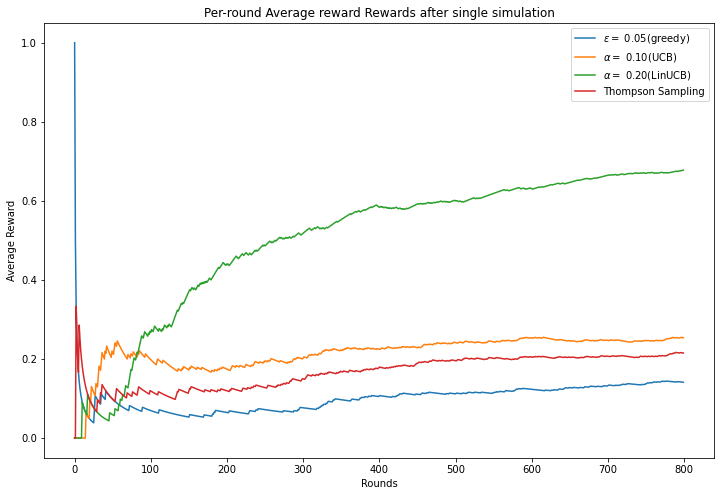

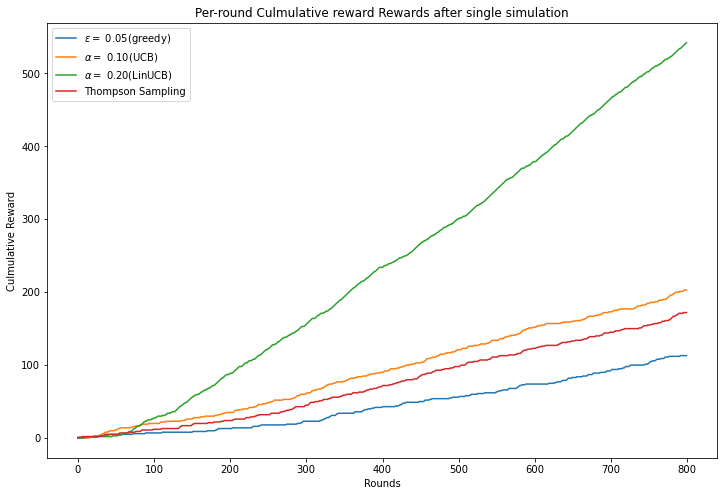

In [42]:
JOBS = 1
test_rounds = 800
np.random.seed(1)
data = np.loadtxt('dataset.txt')
datalen = np.shape(data)[0]
arms = data[:, 0]
rewards = data[:, 1]
contexts = data[:, 2:102]

epsilon = 0.05
alpha = 0.1
alpha2 = 0.2

mab1 = EpsilonGreedy(10,epsilon)
mab2 = UCB(10, alpha)
mab3 = BetaThompsonSampling(10, 1.0, 1.0)
mab4 = LinUCB(10, 10 ,alpha2)

cul_TS = 0
cul_Eps = 0
cul_UCB = 0
cul_LinUCB = 0

cul2_TS = np.zeros(test_rounds)
cul2_Eps = np.zeros(test_rounds)
cul2_UCB = np.zeros(test_rounds)
cul2_LinUCB = np.zeros(test_rounds)

for j in range(JOBS):
    results_Eps, _ , cumulative_reward_Eps = offlineEvaluate(
        mab1, datalen, arms, rewards, contexts, test_rounds)
    results_UCB, _ , cumulative_reward_UCB = offlineEvaluate(
        mab2, datalen, arms, rewards, contexts, test_rounds)
    results_TS, _ , cumulative_reward_TS = offlineEvaluate(
        mab3, datalen, arms, rewards, contexts, test_rounds)
    results_LinUCB, _ , cumulative_reward_LinUCB = offlineEvaluate(
        mab4, datalen, arms, rewards, contexts, test_rounds)
    
    cul_TS += np.mean(results_TS)
    cul_Eps += np.mean(results_Eps)
    cul_UCB += np.mean(results_UCB)
    cul_LinUCB += np.mean(results_LinUCB)

    cul2_TS += cumulative_reward_TS
    cul2_Eps += cumulative_reward_Eps
    cul2_UCB += cumulative_reward_UCB
    cul2_LinUCB += cumulative_reward_LinUCB

print('Epsilon-greedy average reward', cul_Eps/JOBS)    
print('UCB average reward', cul_UCB/JOBS)
print('Thompson Sampling average reward', cul_TS/JOBS)
print('LinUCB-greedy average reward', cul_LinUCB/JOBS)   


plt.figure(figsize=(12, 8))
plt.plot((cul2_Eps/JOBS)/(np.linspace(1, test_rounds, test_rounds)),label=r"$\epsilon=$ {:.2f}(greedy)".format(epsilon))
plt.plot((cul2_UCB/JOBS)/(np.linspace(1, test_rounds, test_rounds)),label=r"$\alpha=$ {:.2f}(UCB)".format(alpha))
plt.plot((cul2_LinUCB/JOBS)/(np.linspace(1, test_rounds, test_rounds)),label=r"$\alpha=$ {:.2f}(LinUCB)".format(alpha2))
plt.plot((cul2_TS/JOBS)/(np.linspace(1, test_rounds, test_rounds)),label=r"Thompson Sampling")

plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Average Reward")
plt.title("Per-round Average reward Rewards after single simulation")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(cul2_Eps/JOBS,label=r"$\epsilon=$ {:.2f}(greedy)".format(epsilon))
plt.plot(cul2_UCB/JOBS,label=r"$\alpha=$ {:.2f}(UCB)".format(alpha))
plt.plot(cul2_LinUCB/JOBS,label=r"$\alpha=$ {:.2f}(LinUCB)".format(alpha2))
plt.plot(cul2_TS/JOBS,label=r"Thompson Sampling")

plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Culmulative Reward")
plt.title("Per-round Culmulative reward Rewards after single simulation")
plt.show()

## 参考

1. [Li, Lihong, et al. "A contextual-bandit approach to personalized news article recommendation." *Proceedings of the 19th international conference on World wide web*. 2010.](https://dl.acm.org/doi/pdf/10.1145/1772690.1772758)
2. Multi-Armed Bandit: LinUCB 1 - 苍耳的文章 - 知乎 https://zhuanlan.zhihu.com/p/545790329
3. A Contextual-Bandit Approach to Personalized News Article Recommendation：论文精读 - 北土城倒8号线的文章 - 知乎 https://zhuanlan.zhihu.com/p/34940176
4. [Multi-armed-Bandits](https://github.com/akhadangi/Multi-armed-Bandits)